<a href="https://colab.research.google.com/github/InwooJeong/sesacMLPro/blob/main/example(Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 차이점



- 머신러닝
    - **데이터**, **정답** => **학습** => 잘 분류해 내는 **규칙**을 찾아낸다
    - (이규칙을 적용한 알고리즘이 예측을 수행한다)
- 기존 프로그래밍
    - 데이터 => 규칙(로직) => 정답

# kaggle 머신러닝 경쟁대회 워크폴로우

- 대회 과제 이해
    - 주제, 평가도구, 장르, 데이터 볼륨, 규칙
- 데이터 수집
    - 통상 제공함
    - 외부 데이터 사용 가능한지 체크
- 데이터 준비/분석
    - 머신러닝 스타일의 **EDA**
        - 범주형(명목형,순서형), 수치형(연속형, 이산형) 기준으로 나눈다
        - 피처엔지니어링의 전략 수립
- 모델구축 (필요한 만큼 반복:에자일 개발 방법론 적용)
    - **피처엔지니어링**
        - 인코딩, 스케일링(정규화 포함), 피처 제거,이상치/결측 처리, 파생피처 ....
    - 베이스라인 구축
        - submission 파일 생성 및 제출 (테스트 데이터 사용)
    - **최적** 알고리즘 선정
        - 전통기법:하이퍼파라미터튜닝, 파이프라인등...
            - 제출
        - 베이지안 최적화
            - 제출
        - AutoML-파이캐럿
            - 제출
    - 성능향상이나, 피처엔지니어링은 필요한 만큼 반복
- 최종 제출
    - 전체 코드가 한번에 작동하도록 노트 조정
        - 국내는 제출, git에 관리용
    - 제출
        - 아래 점수 체크
            - private score
            - public score

# 연구목표

- 범주형 데이터 이진 분류
- 정답 데이터
    - 정답은 0 아니면 1이다
    - sample_submission.csv을 오픈해서 확인 => 0.5 확률로 보인다
        - **predict_proba**() 사용
        - 정답이 1일 확률
- 목표
    - **kaggle 대회 진행 방식 이해**
    - **피처 엔지니어링**
    - **모델 최적화 기법(파이캐럿등등 사용)**

# 데이터 획득

- 캐글에서 제공(여기서는 제공)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
# train.csv, test.csv, sample_submission.csv 3개 파일 로드
# 단 id 컬럼은 인덱스로 지정 (train, test만)
import os
# csv -> df 로드
path        = '/content/drive/MyDrive/머신러닝/Q1'
train       = pd.read_csv( os.path.join( path, 'train.csv'),  index_col='id')
test        = pd.read_csv( os.path.join( path, 'test.csv'),   index_col='id')
submssion   = pd.read_csv( os.path.join( path, 'sample_submission.csv') )

# train의 상위값 2개 확인
train.head(2)

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# train의 컬럼명 확인
'''
   - bin_0~4 : 이진(바이너리) 피처 (고유값 2개)
   - nom_0~nom_9 : 범주형(명목형) 피처 (고유값 각각 다를듯)
   - ord_0~ord_5 : 범주형(순서형) 피처 -> 순서가 어떤 것을 표방하는지 중요
   - 'day'   : 고유값 7개 (요일)
   - 'month' : 고유걊 12개 : 1월~12월
   - 'target' : 정답 (0 혹은 1)
'''
train.columns

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
       'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'target'],
      dtype='object')

In [9]:
# 데이터 볼륨
train.shape, test.shape, submssion.shape
# test의 피처수가 train보다 작음 => target 부분이 없다
# test데이터와 submssion의 데이터수가 일치 => 제출할때 예측한 데이터

((300000, 24), (200000, 23), (200000, 2))

- 현재 데이터 기준 피처별 샘플 데이터, 고유값의 수등등 집계하기가 어렵다(파악하기 어려움)
- 피처 요약표 구현
    - 수직으로 표현

In [10]:
train.head(2).T

id,0,1
bin_0,0,0
bin_1,0,1
bin_2,0,0
bin_3,T,T
bin_4,Y,Y
nom_0,Green,Green
nom_1,Triangle,Trapezoid
nom_2,Snake,Hamster
nom_3,Finland,Russia
nom_4,Bassoon,Piano


# 데이터 준비 및 분석

- 피처 요약표 구성(함수)
- 피처 엔지니어링을 위한 기본 EDA 진행
    - 피처 엔지니어링 전략 수립

## 피처 요약표

- 피처명, 형상, 타입, 결측치, 고유값수, 샘플값
- DF로 구성

In [11]:
# F:0, T:1
# Series = 인덱스 + 데이터
# DataFrame = 인덱스 + 데이터 + 컬럼
train.isnull().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [12]:
# 고유값 : Series는 unique() 통해서 구한다 => 고유값을 구한다
train.bin_0.unique(), len(train.bin_0.unique())

(array([0, 1]), 2)

In [13]:
# DataFrame에서는 nunique() 개수를 구함
train.nunique().values

array([    2,     2,     2,     2,     2,     3,     6,     6,     6,
           4,   222,   522,  1220,  2215, 11981,     3,     5,     6,
          15,    26,   192,     7,    12,     2])

In [14]:
train.head(3)

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0


In [15]:
train.loc[2].values

array([0, 0, 0, 'F', 'Y', 'Blue', 'Trapezoid', 'Lion', 'Russia',
       'Theremin', '3263bdce5', '0922e3cb8', 'a6a36f527', 'de9c9f684',
       'ae6800dd0', 1, 'Expert', 'Lava Hot', 'h', 'R', 'Jc', 7, 2, 0],
      dtype=object)

In [16]:
def summary_feature_info( df ):
    '''
        피처명, 형상, 타입, 결측치, 고유값수, 샘플값 구성된 df를 리턴한다
    '''
    #print(df.dtypes)
    # df.dtypes 인덱스명 그대로 인덱스, 타입이 컬럼으로 설정
    sub_df = pd.DataFrame( df.dtypes, columns=['type'])
    # 피처명도 하나의 데이터 -> 인덱스를 컬럼으로 이동
    sub_df = sub_df.reset_index()
    # 특정 컬럼명 변경(원본 반영 포함)
    sub_df.rename( columns={'index':'feature_name'}, inplace=True)
    # 결측치 수 -> 파생변수
    sub_df['결측치수'] = df.isnull().sum().values
    # 고유값수 -> 파생변수
    sub_df['고유값수'] = df.nunique().values
    # 샘플값_0 -> 파생변수
    sub_df['샘플값_0'] = df.loc[0].values
    # 샘플값_1 -> 파생변수
    sub_df['샘플값_1'] = df.loc[1].values
    # 샘플값_2 -> 파생변수
    sub_df['샘플값_2'] = df.loc[2].values
    return sub_df

summary_feat_df = summary_feature_info( train )
summary_feat_df

,feature_name,type,결측치수,고유값수,샘플값_0,샘플값_1,샘플값_2
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin


## 피처 요약표 기준 피처 엔니어링 전략 수립

### bin_

In [17]:
# bin_ 피처 요약표 (처음부터 5개 데이터만 추출)
summary_feat_df.loc[:4]

,feature_name,type,결측치수,고유값수,샘플값_0,샘플값_1,샘플값_2
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y


- 총 피처 5개
- 고유값은 피처별 2개 (bin 네이밍과 의미가 동일)
- 전처리 대상
    - **bin_3, bin_4** 는 object 타입 => 수치형으로 변환 필요:**인코딩처리**
    - **피처엔니어링에서 처리**

In [18]:
# 실제 고유값 확인
for i in range(5):
    name = f'bin_{i}'
    print( name, train[name].unique() )

bin_0 [0 1]
bin_1 [0 1]
bin_2 [0 1]
bin_3 ['T' 'F']
bin_4 ['Y' 'N']


### nom_

In [19]:
# nom_0 ~ nom_9
summary_feat_df.loc[5:5+9]

,feature_name,type,결측치수,고유값수,샘플값_0,샘플값_1,샘플값_2
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin
10,nom_5,object,0,222,50f116bcf,b3b4d25d0,3263bdce5
11,nom_6,object,0,522,3ac1b8814,fbcb50fc1,0922e3cb8
12,nom_7,object,0,1220,68f6ad3e9,3b6dd5612,a6a36f527
13,nom_8,object,0,2215,c389000ab,4cd920251,de9c9f684
14,nom_9,object,0,11981,2f4cb3d51,f83c56c21,ae6800dd0


- nom_5 ~ nom_9
    - 데이터가 범주형이지만, 해시값이다(실체는 감춰져 있다)
    - 전략
        - 제거
        - 데이터 그대로 사용
- 전체 데이터는 문자열
    - 인코딩 처리 필요
    - **원-핫 인코딩 처리(+ 압축 포멧 사용)**
        - 해시 인코딩, 빈도 인코딩등등 고려
        - 고유값의 개수 만큰 피처수가 늘어나서, 연산비용이 증가

### ord_

In [20]:
summary_feat_df.loc[15:15+5]

,feature_name,type,결측치수,고유값수,샘플값_0,샘플값_1,샘플값_2
15,ord_0,int64,0,3,2,1,1
16,ord_1,object,0,5,Grandmaster,Grandmaster,Expert
17,ord_2,object,0,6,Cold,Hot,Lava Hot
18,ord_3,object,0,15,h,a,h
19,ord_4,object,0,26,D,A,R
20,ord_5,object,0,192,kr,bF,Jc


- 순서형 데이터는 순서대로 배치하는것 중요
- 고유값의 수가 전체 데이터 수보다는 작으므로 모두 학습에 사용
- 순서형으로 타입을 적용한후 인사이트 도출!!
    - EDA에서 추가 확인

In [21]:
# 실제 고유값 확인
for i in range(6):
    name = f'ord_{i}'
    print( name, train[name].unique() )

# 1->2->3
# 캐글 등급 -> 아래 등급에 맞춰서 ordinal 인코딩 수행
# 'Novice' -> 'Contributor' -> 'Expert' -> 'Master' -> 'Grandmaster'
# 온도 레벨
# 'Freezing' -> 'Cold' -> 'Warm' -> 'Hot' -> 'Boiling Hot' -> 'Lava Hot'
# 나머지는 알파벳순

ord_0 [2 1 3]
ord_1 ['Grandmaster' 'Expert' 'Novice' 'Contributor' 'Master']
ord_2 ['Cold' 'Hot' 'Lava Hot' 'Boiling Hot' 'Freezing' 'Warm']
ord_3 ['h' 'a' 'i' 'j' 'g' 'e' 'd' 'b' 'k' 'f' 'l' 'n' 'o' 'c' 'm']
ord_4 ['D' 'A' 'R' 'E' 'P' 'K' 'V' 'Q' 'Z' 'L' 'F' 'T' 'U' 'S' 'Y' 'B' 'H' 'J'
 'N' 'G' 'W' 'I' 'O' 'C' 'X' 'M']
ord_5 ['kr' 'bF' 'Jc' 'kW' 'qP' 'PZ' 'wy' 'Ed' 'qo' 'CZ' 'qX' 'su' 'dP' 'aP'
 'MV' 'oC' 'RL' 'fh' 'gJ' 'Hj' 'TR' 'CL' 'Sc' 'eQ' 'kC' 'qK' 'dh' 'gM'
 'Jf' 'fO' 'Eg' 'KZ' 'Vx' 'Fo' 'sV' 'eb' 'YC' 'RG' 'Ye' 'qA' 'lL' 'Qh'
 'Bd' 'be' 'hT' 'lF' 'nX' 'kK' 'av' 'uS' 'Jt' 'PA' 'Er' 'Qb' 'od' 'ut'
 'Dx' 'Xi' 'on' 'Dc' 'sD' 'rZ' 'Uu' 'sn' 'yc' 'Gb' 'Kq' 'dQ' 'hp' 'kL'
 'je' 'CU' 'Fd' 'PQ' 'Bn' 'ex' 'hh' 'ac' 'rp' 'dE' 'oG' 'oK' 'cp' 'mm'
 'vK' 'ek' 'dO' 'XI' 'CM' 'Vf' 'aO' 'qv' 'jp' 'Zq' 'Qo' 'DN' 'TZ' 'ke'
 'cG' 'tP' 'ud' 'tv' 'aM' 'xy' 'lx' 'To' 'uy' 'ZS' 'vy' 'ZR' 'AP' 'GJ'
 'Wv' 'ri' 'qw' 'Xh' 'FI' 'nh' 'KR' 'dB' 'BE' 'Bb' 'mc' 'MC' 'tM' 'NV'
 'ih' 'IK' 'Ob' 'RP' 'dN' 'us' 'd

### day, month

- 순환형 (순서는 존재, 서열은 없다)
    - 월 -> 화 -> ... 일 -> 월
    - 머신러닝은 이웃값을 비슷한것으로 인지
        - 이를 제거하기 위해서 원-핫 인코딩 적용

In [22]:
train['day'].unique()

array([2, 7, 5, 4, 3, 1, 6])

In [23]:
train['month'].unique()

array([ 2,  8,  1,  4, 10,  3,  7,  9, 12, 11,  5,  6])

### target

In [24]:
train['target'].unique()

array([0, 1])

## EDA를 이용하여 데이터 분석

- 사용하고자 하는 데이터에 대한 이해, 사용 여부를 결정
- 인사이트 도출 => 분석
- **인사이트가 있는것이 보이고, 데이터들간에 구분(격차(차이존재)) 이 잘 되면 => 학습에 도움이 되겠다 판단(사용 혹은 제거)**

- 목표
    - 피처 데이터
        - 고유값들의 비중 검사
            - 바차트 확률이 높음
            - 데이터의 불균형도 점검
    - 타겟 데이터
        - 정답 1에 대한 확률, 비율 체크
        - 고유 피처별 대비 타겟 데이터 의 비율 점검

- EDA
    - 수치형 : displot()
    - 범주형 : countplot()
    - 기타 필요시 추가

In [25]:
import seaborn as sns

### 타겟값 분포 + 카운트플롯(커스텀)

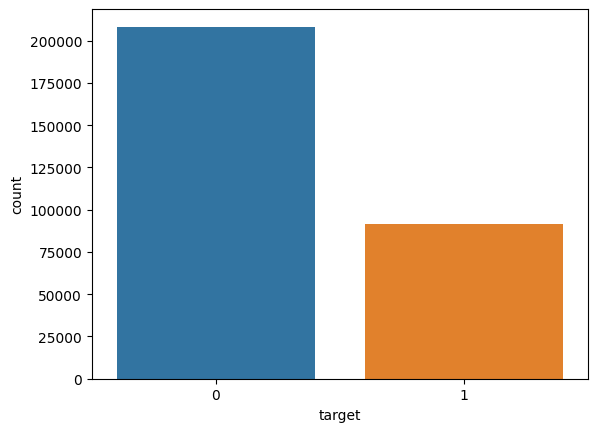

In [26]:
# target 컬럼값( 0 or 1)의 빈도를 바차트 묘사
# train에서 target 컬럼기반 집계 -> size()를 구해서 시각화
sns.countplot( data=train, x='target', );

# 0이 1보다 대략 2배 정도 비율로 데이터가 더 많다 => 불균형 => 층화를 처리?
# 바차트 위에서 비율을 같이 표기하는 커스텀 카운트플롯 구성

[69.41199999999999, 30.587999999999997]

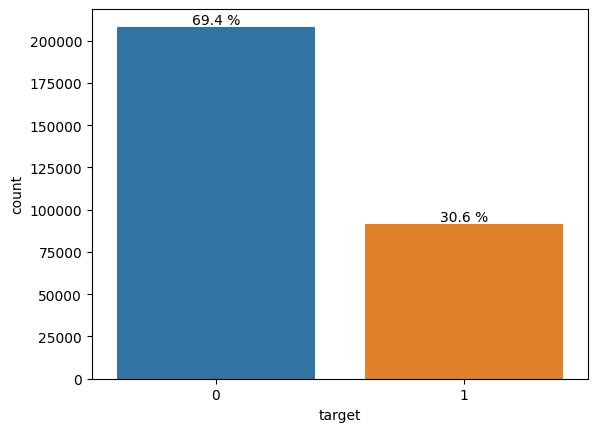

In [27]:
# 향후 계속 사용 가능한 모듈
def draw_text_by_ax( ax, data ):
    '''
        ax:차트의 축정보를 접근가능한 객체
        data:표기할 정보를 계산할 데이터(여기서는 비중 x%)
    '''
    #print( '->', ax.patches )
    percents = list() # 카운트 바 별 비율을 저장할 그릇
    for bar in ax.patches: # 개별 바 정보 접근
        percent = bar.get_height() / data.shape[0] * 100 # 개별카운트/전체데이터수
        # bar를 이용하여 바의 좌표 정보 획득
        ax.text( x = bar.get_x() + bar.get_width()/2,
                 y = bar.get_y() + bar.get_height() + data.shape[0]*0.005,
                 s = f'{percent:1.1f} %',
                 ha= 'center'
                 )
        percents.append( percent )
    # 리턴 : 차트축정보, 비중정보
    return ax, percents

_, rates = draw_text_by_ax( sns.countplot( data=train, x='target'), train )
rates

- 타겟중 0와 1의 비율
    - 0:1 = 69.4:30.6
    - 불균형, 층화 처리 예상
    - 다른 고유값들도 이 비율을 유지하는가?

### bin_ 피처 데이터의  EDA

- 범주형 피처의 고유값별 타겟값 비중 확인
    - ex) Y를 값으로 가진 모든 데이터들 중에서 정답이 0인 개수, 1인 개수 => 비율체크 => 전체 데이터상에서 0과 1의 비율과 유사하게 가는가? 차이점이 존재하는가? 체크

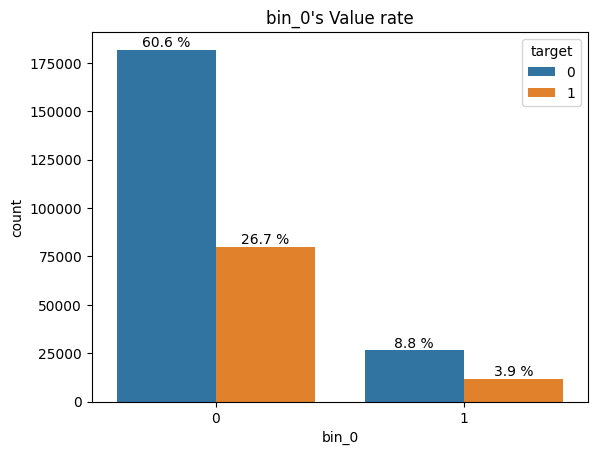

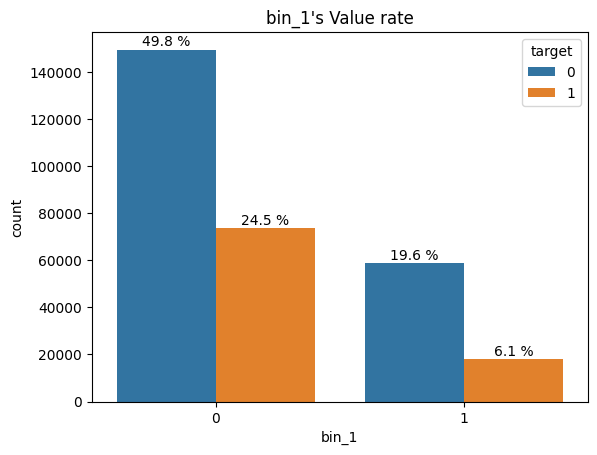

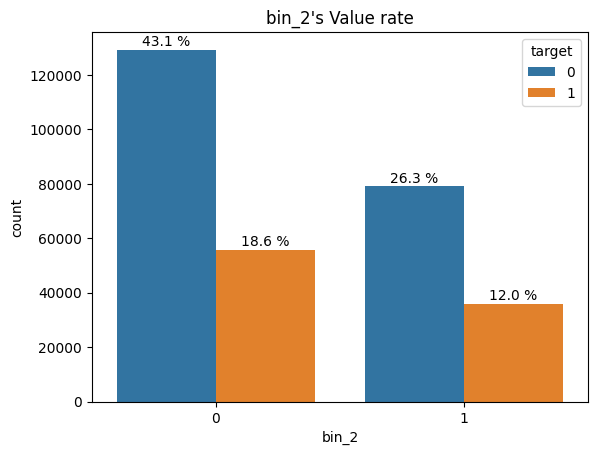

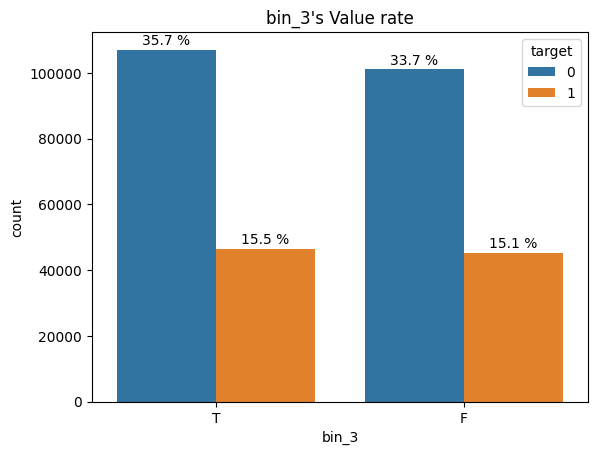

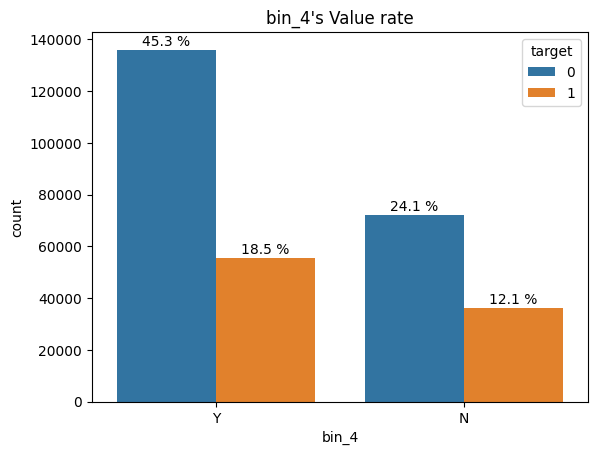

In [28]:
# 해당 피처명 생성 (bin_0, bin_1, ...)
bin_features = [ f'bin_{x}' for x in range(5)]

bin_logs = dict()
for bin_feature in bin_features:
    # 피처별 고유값의 빈도 + 고유값별 정답의 비율추가
    ax, precents = draw_text_by_ax( sns.countplot( data=train, x=bin_feature, hue='target'), train )
    # 퍼센트(피처별 비중) 수집
    bin_logs[ bin_feature ] = precents
    # 차트 출력
    ax.set_title( f'{bin_feature}\'s Value rate' )
    plt.show()

# 피처별 그리고 고유값별 타겟값의 추세는 전체 데이터의 타겟값의 추세와 동일하다
# 단 높낮이만 다를뿐 => 일차적으로 학습에 사용해도 문제가 없다. 높낮이가 달라서
# 데이터를 구분할때(예측시 학습에) 도움이 될듯 => 모두 학습에 사용

In [29]:
bin_logs

{'bin_0': [60.595333333333336,
  8.816666666666666,
  26.654333333333334,
  3.9336666666666664],
 'bin_1': [49.81133333333334, 19.600666666666665, 24.528, 6.0600000000000005],
 'bin_2': [43.07933333333333,
  26.332666666666665,
  18.598333333333333,
  11.989666666666666],
 'bin_3': [35.695, 33.717000000000006, 15.483333333333333, 15.104666666666667],
 'bin_4': [45.346333333333334,
  24.065666666666665,
  18.531333333333333,
  12.056666666666667]}

In [30]:
# df로 구성하여 비중 체크
rate_df = pd.DataFrame(bin_logs)
rate_df

,bin_0,bin_1,bin_2,bin_3,bin_4
0,60.595333,49.811333,43.079333,35.695000,45.346333
1,8.816667,19.600667,26.332667,33.717000,24.065667
2,26.654333,24.528000,18.598333,15.483333,18.531333
3,3.933667,6.060000,11.989667,15.104667,12.056667


In [31]:
# index 0, 2 번은 각각 고유값에서 타겟값 0이 차지하는 비율
# index 1, 3 번은 각각 고유값에서 타겟값 1이 차지하는 비율

# 다양한 비교 케이스가 존재할수 있고 고유값별 0이 차지하는 비중 계산
rate_df.iloc[ 0 ]/rate_df.iloc[ 2 ]
# 첫번째 고유값이 두번째 고유값에 비해 2~2.4배 정도 타겟값0을 더 많이 가지고 있다
# 추세는 비슷, 개별값이 다름 => 학습에 도움이 된다 => 학습에 사용
# 차후 bin_2와 bin_3는 피처 제거시 유사성이 보일 가능성이 크므로 검토후 제거할수 있다

bin_0    2.273376
bin_1    2.030795
bin_2    2.316301
bin_3    2.305382
bin_4    2.447009
dtype: float64

### nom_ 피처 데이터의 EDA

- 특징
    - 고유값이 6개 미만 피처
        - EDA 진행
    - 고유값이 6개 이상 천단위까지 존재 피처
        - 피처엔니어링 > 피처 인코딩때 검토
            - 데이터가 모두 해시처리 되어 있음
            - 원-핫 인코딩 처리를 목표(0와 1로 표현)
            - 피처 제거도 검토
            - 해싱 인코딩 혹은 빈도(프리퀀스)인코딩 전략도 검토
- 시각화
    - 데이터 교차 분석표 기반
    - 2개 차트 혼합
        - x축 피처별 고유값
        - y축
            - left 축
                - 고유값의 카운트(몇번 등장)
                - 카운트 플롯
            - right 축
                - 정답 1에 대한 고유값별 차지하는 비율
                - 포인트 플롯(점을 찍고, 선으로 연결) -> 추세

#### 데이터 교차 분석표

- cross-tabulation
- 범주형 데이터를 2개를 분석할때 사용
- 빈도와 통계량을 행렬로 결합한표
- 정답 별 고유값별로 차지하는 비율 계산

In [32]:
pd.crosstab( train.nom_0, train.target )

target,0,1
nom_0,,
Blue,72914,23252
Green,85682,41659
Red,49640,26853


In [33]:
# 백분율로 표현
cross_tab = pd.crosstab( train.nom_0, train.target, normalize='index' )*100
cross_tab

target,0,1
nom_0,,
Blue,75.820976,24.179024
Green,67.285478,32.714522
Red,64.894827,35.105173


In [34]:
# 인덱스 초기화 -> 인덱스가 컬럼으로 이동
cross_tab.reset_index(inplace=True)
cross_tab

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


In [35]:
# nom_0 ~ nom_4 등 다 이 처리해야 하므로 함수화 필요
def make_cross_tabul( df, f_nm, t_nm ):
    cross_tab = pd.crosstab( df[f_nm], df[t_nm], normalize='index' )*100
    cross_tab.reset_index(inplace=True)
    return cross_tab

cross_tab = make_cross_tabul( train, 'nom_1', 'target')
cross_tab

target,nom_1,0,1
0,Circle,75.434084,24.565916
1,Polygon,68.453089,31.546911
2,Square,66.106821,33.893179
3,Star,68.937348,31.062652
4,Trapezoid,70.994554,29.005446
5,Triangle,63.902194,36.097806


In [36]:
# 고유값별 정답 1에 대한 비율
# [1] => 1은 컬럼명이 1이여서 1을 사용한것
cross_tab[1]
#cross_tab.iloc[ :, -1]

0    24.565916
1    31.546911
2    33.893179
3    31.062652
4    29.005446
5    36.097806
Name: 1, dtype: float64

#### 포인트 플롯

- 데이터 포인트 찍고, 라인으로 연결 => 추세

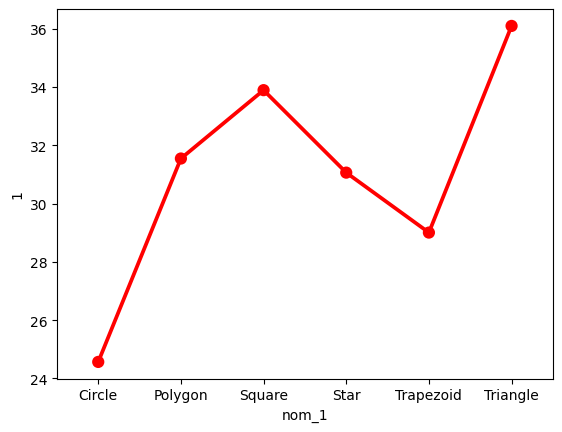

In [37]:
def show_pointplot( x_nm, y_nm, data, color='red', ax=None ):
    sns.pointplot(x=x_nm,           # x축을 담당하는 컬럼명 => 고유값(nom_1)
                  y=y_nm,           # y축을 담당하는 컬럼명 => 타겟값 1
                  data=data,        # 원본데이터 df
                  order=data[x_nm], # x값이 배치되는 순서(순서형에서 의미를 가짐)
                  color=color,      # 색상
                  ax=ax             # 축정보를 세팅해서 한차트에 여러차트 그릴대 활용
                  )
    pass
show_pointplot( 'nom_1', 1, cross_tab )

#### 카운트 플롯 + 포인트 플롯 혼합구성

- 시각화를 통해 해당 피처를 (미?)사용 여부를 1차적으로 판단

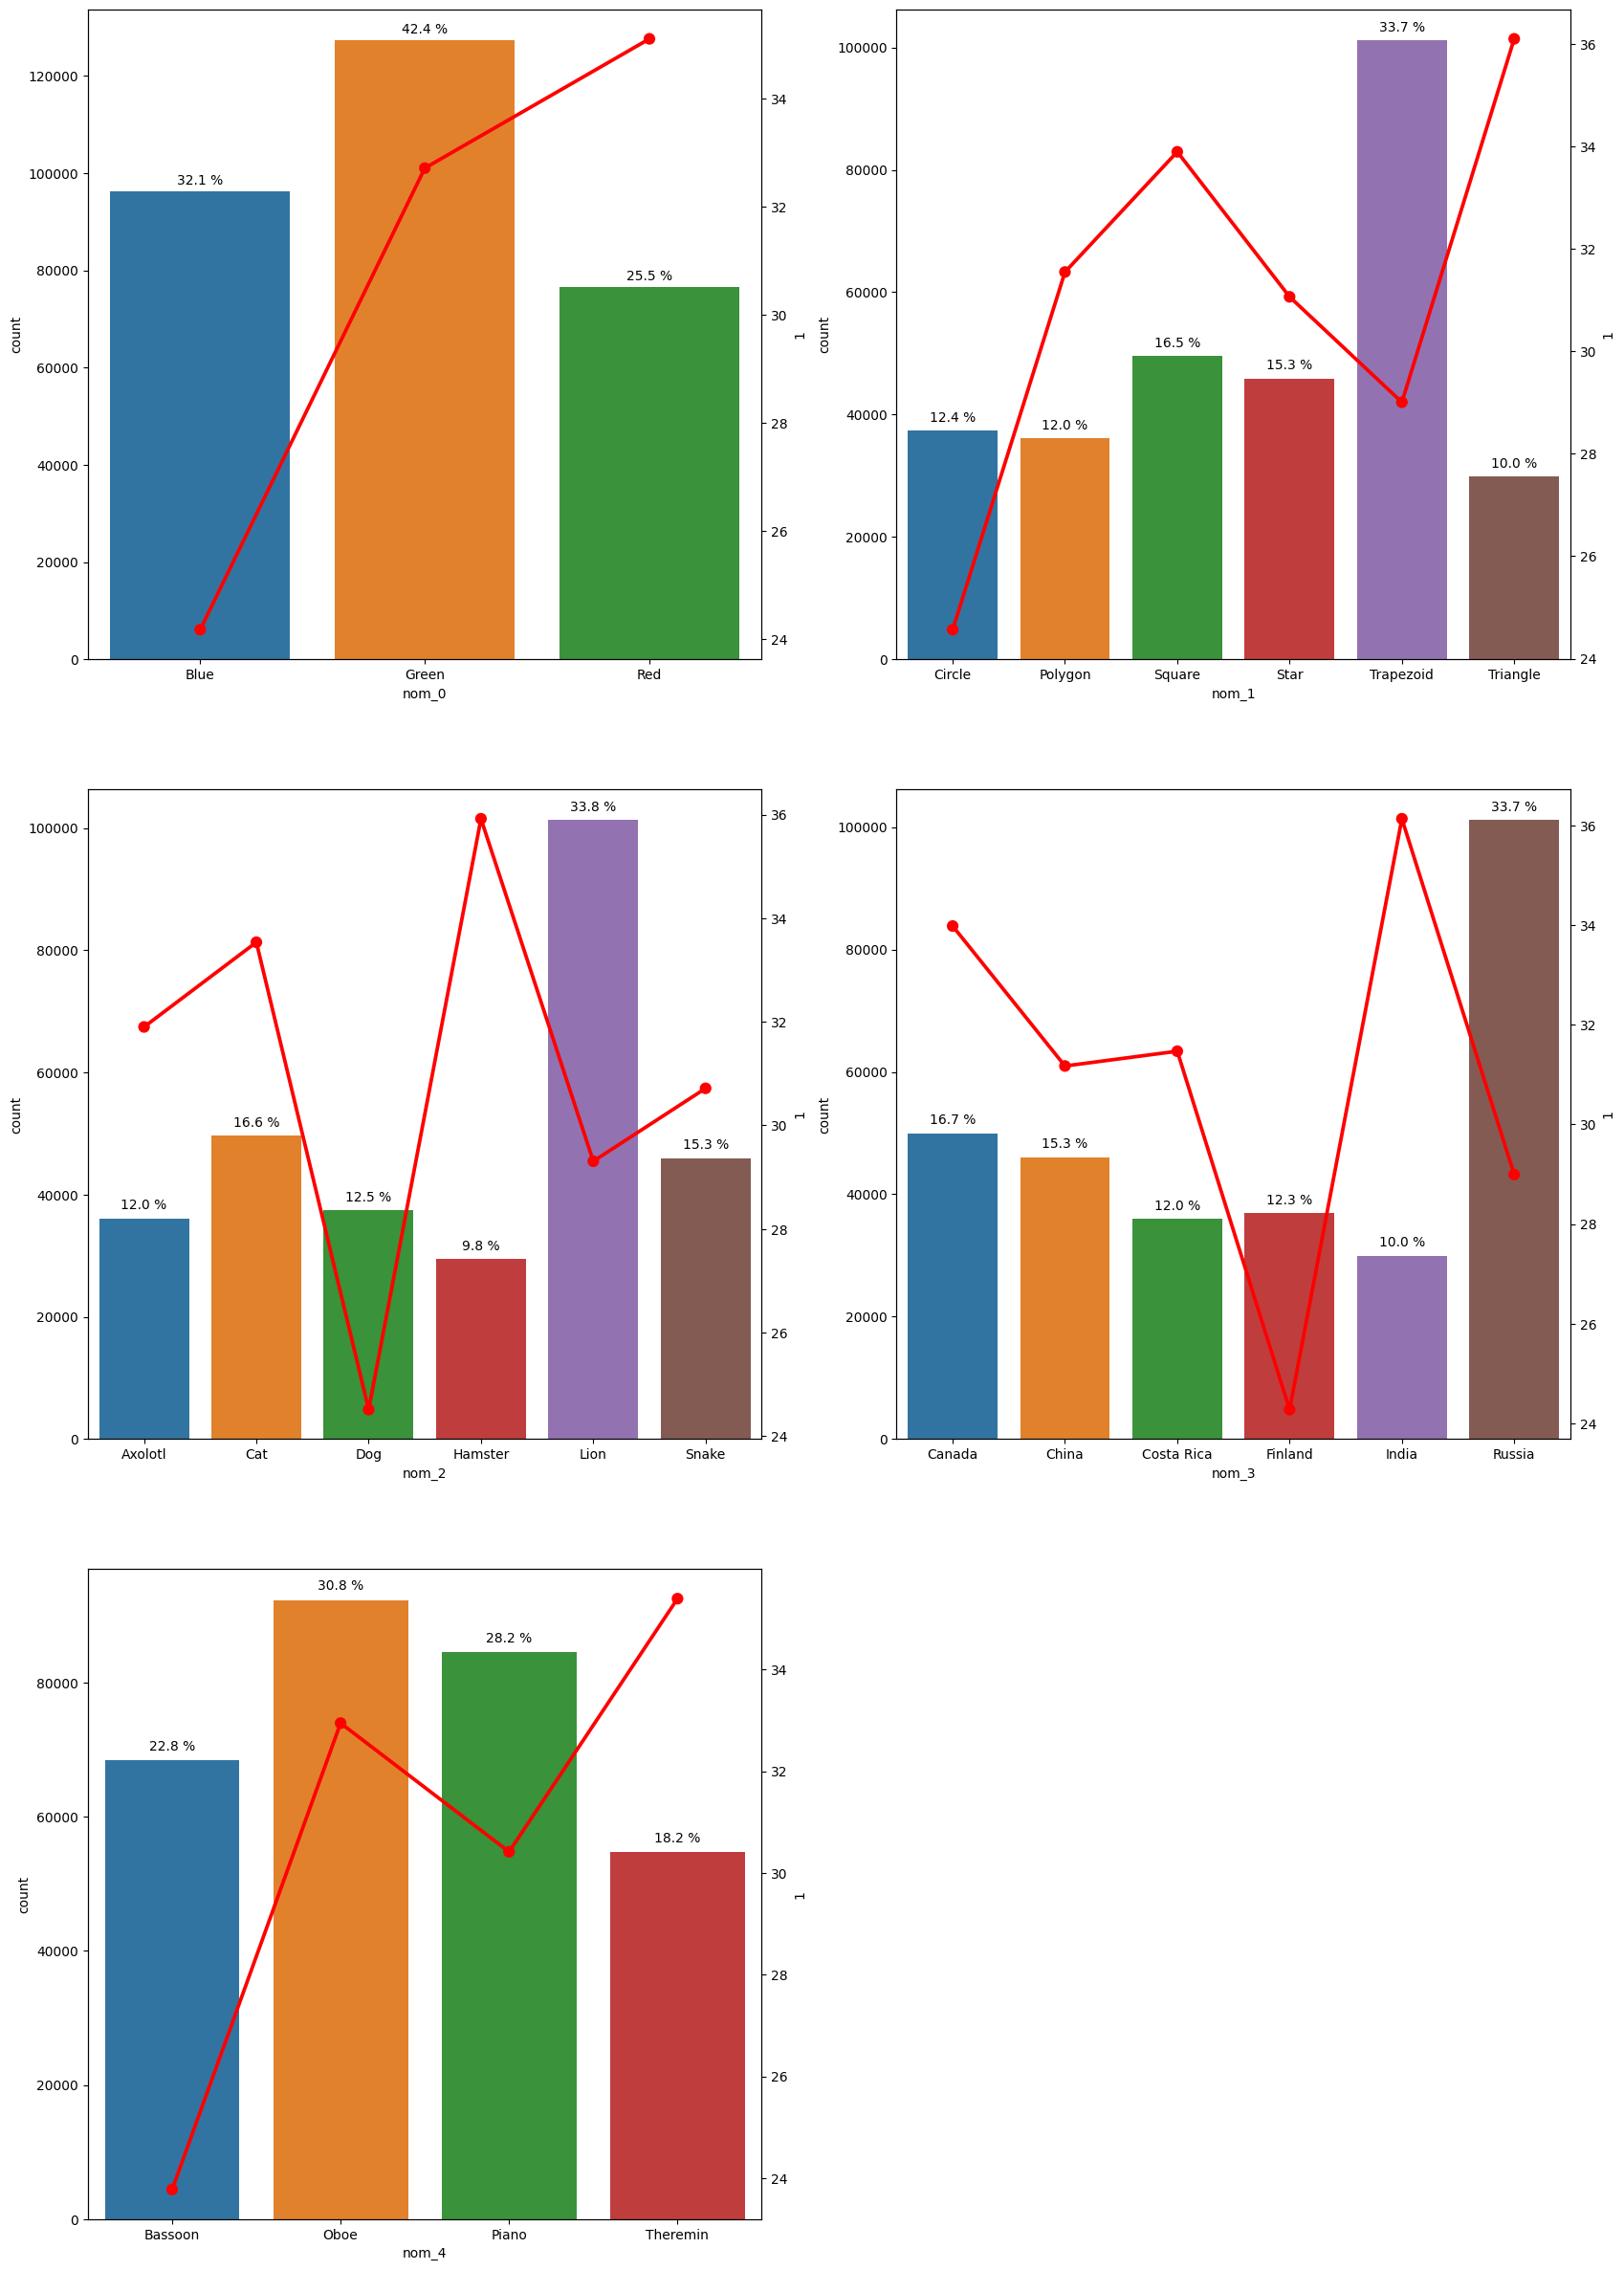

In [38]:
import matplotlib.gridspec as gs # 격자 배치용 모듈 (가로에 2개차트 기준 세로 배치)

# 대상 피처명 : nom_0 ~ 4
nom_features = [ f'nom_{i}' for i in range(5) ]
# nom_features
# 화면상에 5개 차트를 한줄당 2개씩 표현
COLS = 2
ROWS = sum(divmod( len(nom_features), COLS ))
ROWS, COLS

def show_count_point_plot( df, features, t_nm, rows, cols ):
    '''
        df : eda 하고 싶은 원본 데이터 (DataFrame)
        features : 원본데이터에서 추출할 컬럼명들
        t_nm : 정답데이터 컬럼명
        rows, cols : 격자형 차트의 크기
    '''
    # 격자 형태 구성
    plt.figure( figsize=(10*cols,10*rows) )
    # 격자 계산
    gs_grid = gs.GridSpec( rows, cols )
    # gs_grid[0], gs_grid[1], gs_grid[2], ... gs_grid[4]
    # 총 features의 개수만큼 차트를 그린다 -> 반복
    for idx, feature in enumerate(features):
        # 1. ax 축정보 회득 => 어디가가 그릴것인가? => 칸 정보
        ax = plt.subplot( gs_grid[idx] )
        # 2. 교차 분석표 생성
        cross_tab = make_cross_tabul( df, feature, t_nm) #(train, 'nom_0~5', 'target')
        # 3. 카운트 플롯 그리기
        draw_text_by_ax( sns.countplot( data=df, x=feature,
                                        #hue=t_nm,
                                        ax=ax,                   # 차트위치추가
                                        order=cross_tab[feature] # 정렬 추가
                                        )
                        , df  )
        # 4. 포인트 플롯 그리기(오른쪽축)
        show_pointplot( feature, 1, cross_tab, ax=ax.twinx())
        # 5. 제목
        pass

    # 차트폼 출력
    plt.show()
    pass
show_count_point_plot( train, nom_features, 'target', ROWS, COLS )

# 피처별 고유값별 빈도가 상이함, 유사한 빈도를 가져도 정답 1의 비율이 상이함 => 학습에 도움이 된다
# 정답 1에 대한 비율이 모두 상이함 => 예측 능력이 있음 => 학습에 도움이 됨
# 피처(nom_0 ~ 4) 는 모두 학습에 사용하겠다

### ord_ 피처데이터 EDA

- 고유값을 순서형으로 타입을 필요시 맞춘다

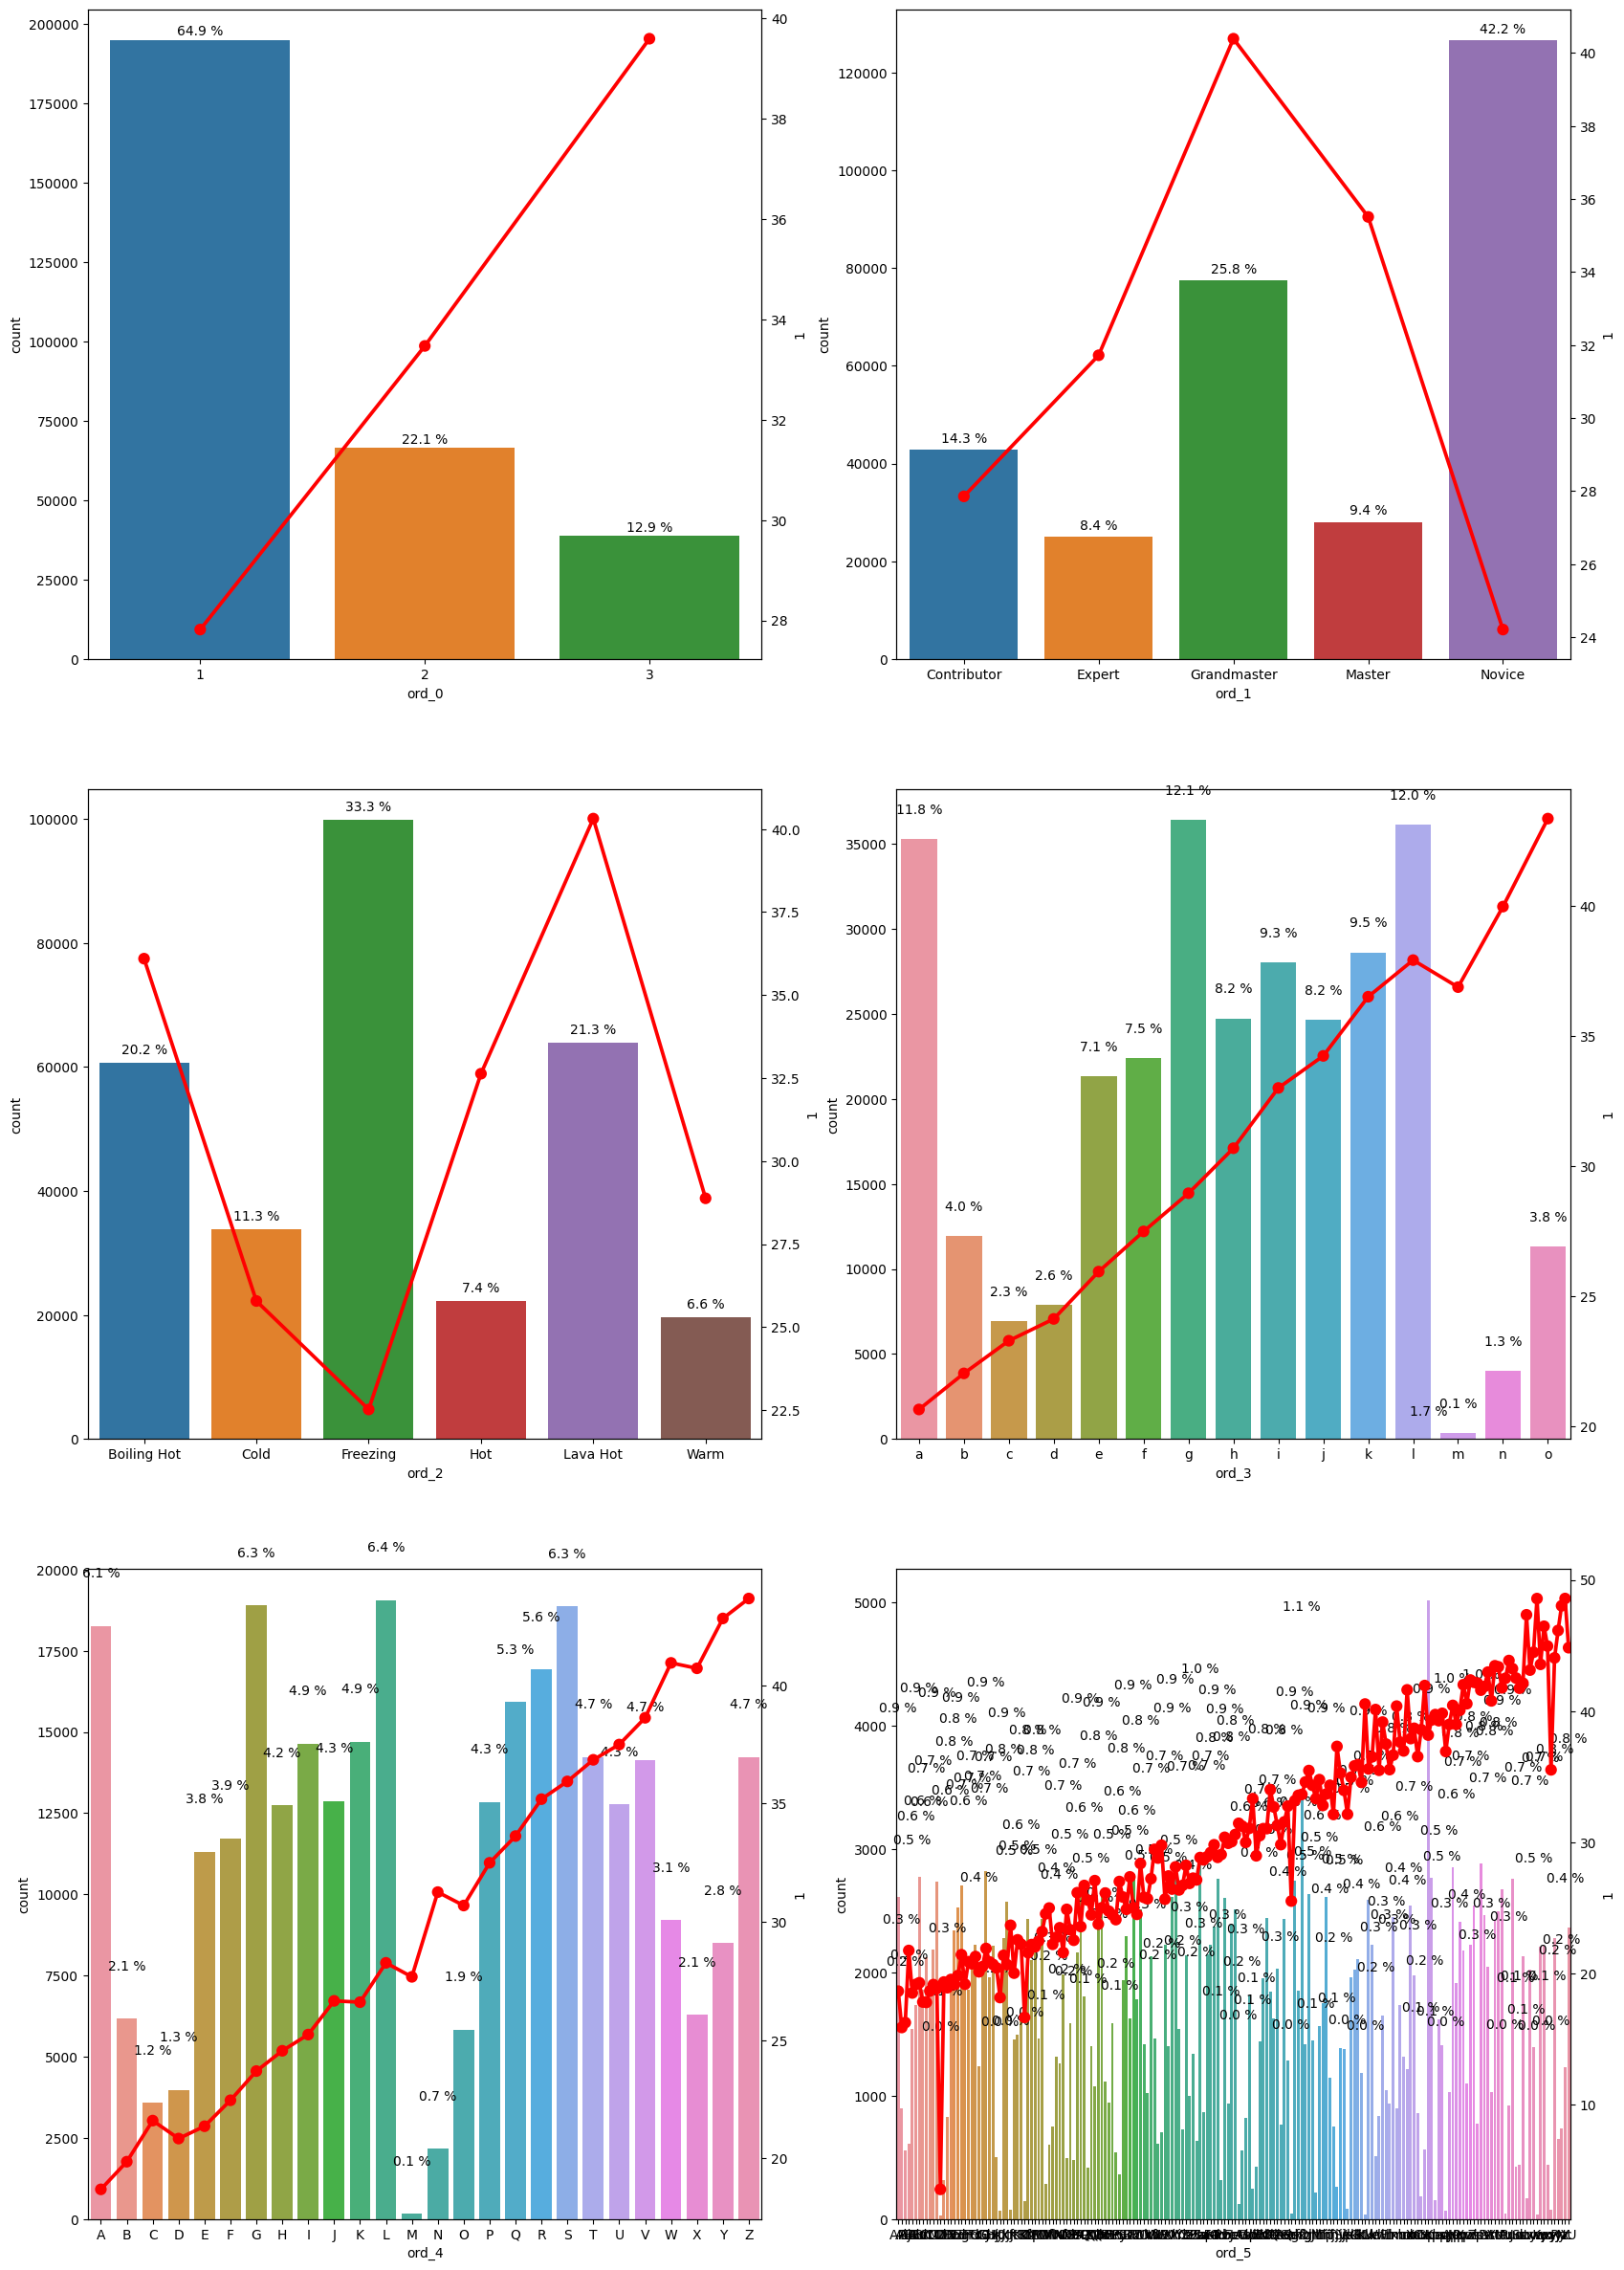

In [39]:
ord_features = [ f'ord_{i}' for i in range(6) ]
show_count_point_plot( train, ord_features, 'target', ROWS, COLS )

# 해석
# ord_1, ord_2번 순서 조정(타입 조정)
# 만약 조정후 모두 정답 1의 빈도가 순서에 따라 비례적으로 상승하는 구조라면
# 선형모델로 이해하고, 학습에 많은 도움이 될것으로 예측
# 로지스틱 회귀를 베이스라인으로 적용 검토
# 이진분류 : 로지스틱회귀, SVM

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 299999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   ord_0   300000 non-null  int64   
 1   ord_1   300000 non-null  category
 2   ord_2   300000 non-null  category
 3   ord_3   300000 non-null  object  
 4   ord_4   300000 non-null  object  
 5   ord_5   300000 non-null  object  
dtypes: category(2), int64(1), object(3)
memory usage: 20.1+ MB
None


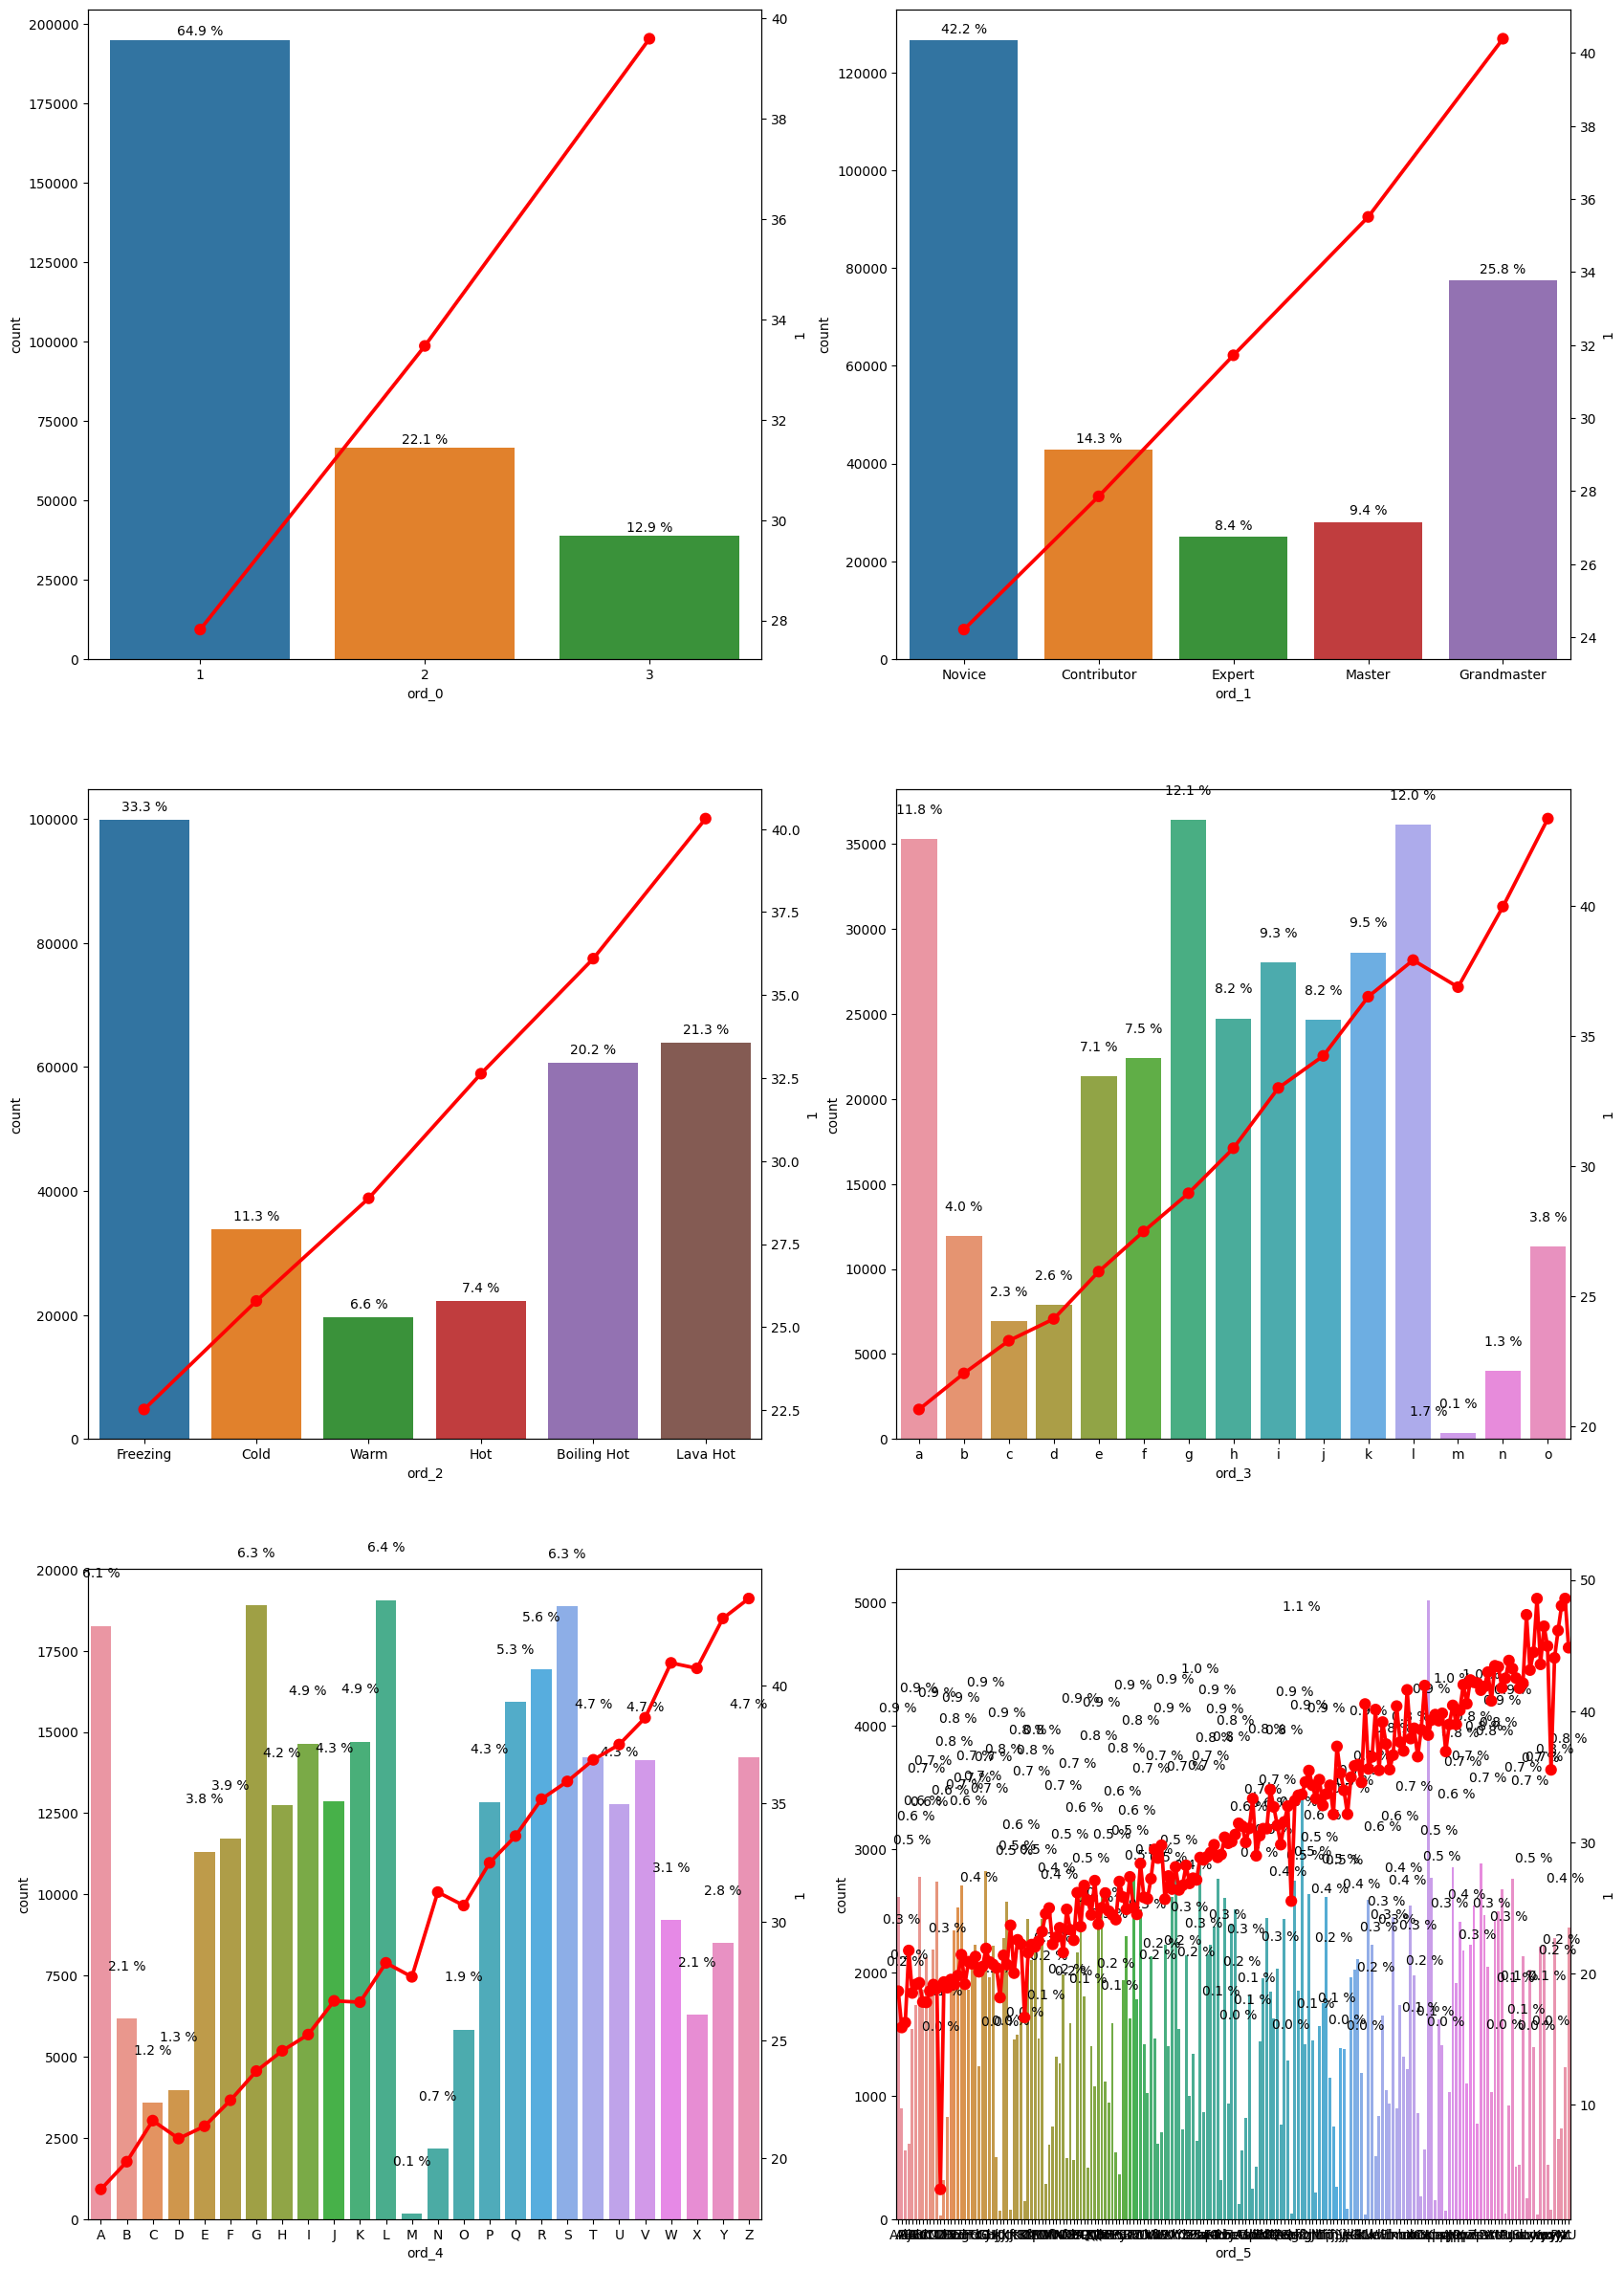

In [40]:
# 피처 순서 조정, 시각화를 위해 임시 조정, 피처엔지니어링에서 실처리
from pandas.api.types import CategoricalDtype

# 캐글 등급 -> 아래 등급에 맞춰서 ordinal 인코딩 수행
# 'Novice' -> 'Contributor' -> 'Expert' -> 'Master' -> 'Grandmaster'
# 온도 레벨
# 'Freezing' -> 'Cold' -> 'Warm' -> 'Hot' -> 'Boiling Hot' -> 'Lava Hot'
ord_1 = ['Novice' , 'Contributor' , 'Expert' , 'Master' , 'Grandmaster']
ord_2 = ['Freezing' , 'Cold' , 'Warm' , 'Hot' , 'Boiling Hot' , 'Lava Hot']

# 순서타입 객체 생성
ord_1_type = CategoricalDtype(ord_1, True)
ord_2_type = CategoricalDtype(ord_2, True)
# 타입 변경 astype() : 형변환
train['ord_1'] = train['ord_1'].astype( ord_1_type )
train['ord_2'] = train['ord_2'].astype( ord_2_type )

# 피처 요약표 확인
print( train[ ord_features ].info() )

show_count_point_plot( train, ord_features, 'target', ROWS, COLS )
# 해석
# 순서형 데이터는 순서가 높아짐에 따라 정답 1의 비율이 높아진다(선형모델을 따름)

### day, month 피처데이터 확인

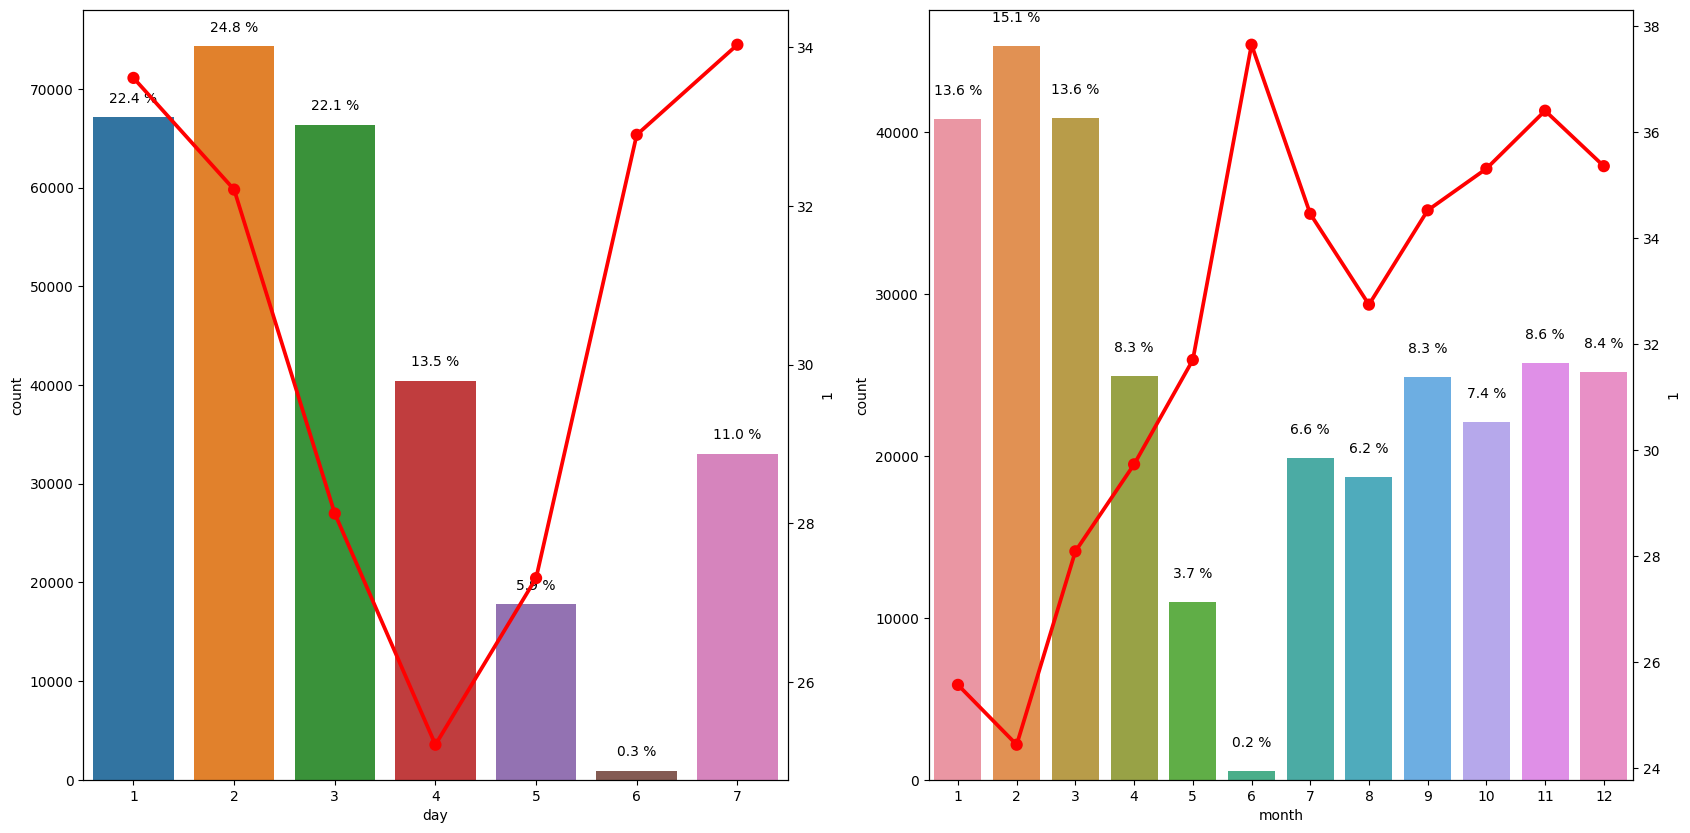

In [41]:
show_count_point_plot( train, ['day','month'], 'target', 1, COLS )
# 해석
# 바차트는 고유값별로 구분이 잘됨
# 1의 비율도 잘 구분됨 => 학습시 사용
# 인코딩
# 순환형(주기형) => 인코딩 전략은 삼각함수 인코딩 사용
# 여기서는 원-핫인코딩 진행 -> 수치에 대한 영향력 제거

# 모델 구축

## 피처엔지니어링

### 피처 인코딩

- 별도 노트로 기본 기능 체크
- 데이터의 수치화, 특수목적을 가지게 조정
- [피처 인코딩](https://colab.research.google.com/drive/1Z9LRgAeGnAkYMawQCsoQND8YlE34ecSK#scrollTo=q2roMIu4X4Es)

In [42]:
# 현재 데이터 확인
train.shape, test.shape

# 전략적으로 훈련 데이터가 부족하면 테스트 데이터를 활용하는 기법도 존재(대회한정)

((300000, 24), (200000, 23))

In [43]:
train.columns

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
       'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'target'],
      dtype='object')

In [44]:
# 필요한 피처 데이터만 추출할수 있게, 피처 이름 생성 함수 준비
def make_feature_names(prefix_str, offset, size):
    return [ f'{prefix_str}_{i}' for i in range( offset, offset+size) ]

make_feature_names( 'bin', 1, 3)

['bin_1', 'bin_2', 'bin_3']

#### bin_

- **bin_3, bin_4** 는 object 타입 => 수치형으로 변환 필요:**인코딩처리**
- **피처엔니어링 > 피처 인코딩에서 처리**

In [45]:
# bin_3 : T -> 1, F -> 0
# bin_4 : Y -> 1, N -> 0
bin_3, bin_4 = make_feature_names( 'bin', 3, 2)

# 변환 -> rename() 형식과 유사한 map()를 활용 -> 1회만 적용(원본 수정했기대문)
train[ bin_3 ] = train[ bin_3 ].map( {'T':1, 'F':0} )
train[ bin_4 ] = train[ bin_4 ].map( {'Y':1, 'N':0} )
train[ [bin_3, bin_4] ].head(2)

,bin_3,bin_4
id,,
0,1,1
1,1,1


In [46]:
# 테스트 데이터 변환
test[ bin_3 ] = test[ bin_3 ].map( {'T':1, 'F':0} )
test[ bin_4 ] = test[ bin_4 ].map( {'Y':1, 'N':0} )

In [47]:
# bin_ 데이터 최종 확인
train[ make_feature_names( 'bin', 0, 5) ].head()

,bin_0,bin_1,bin_2,bin_3,bin_4
id,,,,,
0,0,0,0,1,1
1,0,1,0,1,1
2,0,0,0,0,1
3,0,1,0,0,1
4,0,0,0,0,0


###### 체크

In [48]:
# 피처 요약표 확인
summary_feature_info( train[ make_feature_names( 'bin', 0, 5) ] )

,feature_name,type,결측치수,고유값수,샘플값_0,샘플값_1,샘플값_2
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,int64,0,2,1,1,0
4,bin_4,int64,0,2,1,1,1


#### nom_0~4

- 원-핫 인코딩 처리

In [49]:
from sklearn.preprocessing import OneHotEncoder
# 1. 대상 피처 이름 추출
nom_0_4_feat = make_feature_names('nom', 0, 5)
nom_0_4_feat

# 2. 원본확인
train[ nom_0_4_feat ].head()

# 3. 원-핫 인코딩 처리 -> 훈련용, 테스트용 같이 진행
enc_nom_0_4_train = OneHotEncoder().fit_transform( train[nom_0_4_feat] )#.toarray()
enc_nom_0_4_test  = OneHotEncoder().fit_transform( test[nom_0_4_feat] )

#### nom_5~9

- 고유값이 많은 피처 데이터
    - 제거? (고유값수/데이터수) 고유값 비중이 작아서 배제
- 데이터가 해시
    - 훈련용 데이터와 테스트용 데이터 간에 서로 모르는 고유값이 존재할수 있다
    

In [50]:
summary_feature_info( train[ make_feature_names( 'nom', 5, 5) ] )

,feature_name,type,결측치수,고유값수,샘플값_0,샘플값_1,샘플값_2
0,nom_5,object,0,222,50f116bcf,b3b4d25d0,3263bdce5
1,nom_6,object,0,522,3ac1b8814,fbcb50fc1,0922e3cb8
2,nom_7,object,0,1220,68f6ad3e9,3b6dd5612,a6a36f527
3,nom_8,object,0,2215,c389000ab,4cd920251,de9c9f684
4,nom_9,object,0,11981,2f4cb3d51,f83c56c21,ae6800dd0


In [51]:
test[make_feature_names( 'nom', 5, 5)].nunique().values
#test[ 'nom_5' ].unique

# 고유값의 개수가 훈련용과 테스트용이 다르다 => 여기서는 데이터를 합병해서 처리

array([  222,   522,  1219,  2214, 11839])

In [52]:
# 단순합치기(concat):병합(merge, concat)
nom_5_9_feat = make_feature_names( 'nom', 5, 5) # 대상 피처

temp_nom_5_9_df = pd.concat([ train[nom_5_9_feat], test[nom_5_9_feat] ] ) # 수직으로 붙이기
temp_nom_5_9_df.shape

(500000, 5)

In [53]:
# 원-핫 인코딩 적용
encoder = OneHotEncoder()
encoder.fit( temp_nom_5_9_df ) # 고유값의 최대수로 피처가 체크

# 개별 데이터별로 인코딩 처리
enc_nom_5_9_train = encoder.transform( train[nom_5_9_feat] )
enc_nom_5_9_test  = encoder.transform( test[nom_5_9_feat] )

enc_nom_5_9_train, enc_nom_5_9_test
# 피처는 16251개로 늘어났지만, 학습에 사용 가능함

(<300000x16251 sparse matrix of type '<class 'numpy.float64'>'
 	with 1500000 stored elements in Compressed Sparse Row format>,
 <200000x16251 sparse matrix of type '<class 'numpy.float64'>'
 	with 1000000 stored elements in Compressed Sparse Row format>)

##### 참고:해싱인코딩(해싱트릭)

- 해싱 % 비율
    - 개수를 좁힐수 있다
        - 고유값의 개수를 줄일수 있다
    - **정보 손실이 존재함**


In [54]:
ori_data = '389abcd'
ori_data, hash(ori_data), hash(ori_data) % 100

('389abcd', -2577571951586077193, 7)

In [55]:
# 적용예시
for feat in nom_5_9_feat:
    temp = train[ feat ].apply( lambda x:hash( str(x) ) % 1000  )
    break
temp
# 모든 데이터는 0 ~ 99로만 표현 => 정보손실 발생

id
0         441
1         428
2         710
3          68
4         711
         ... 
299995     57
299996    535
299997    477
299998    716
299999    157
Name: nom_5, Length: 300000, dtype: int64

##### 참고:프리퀀스(빈도) 인코딩

- 특정 고유값이 자주 등장 => 중요하다, 대표값이다. 영향력이 높다
- 고유값의 빈도/전체빈도 -> 값으로 대체+순서적용(높은값이 가장 마지막 단계)

#### ord_

- ord_0
    - 이미 완료 상황
- ord_1~2
    - 순서형 타입으로 변환
    - 순서형인코더 처리 or 기본매핑 처리
- 나머지
    - 순서형인코더 처리

In [56]:
ord_feats = make_feature_names('ord', 0, 6)

summary_feature_info( train[ ord_feats ] )

,feature_name,type,결측치수,고유값수,샘플값_0,샘플값_1,샘플값_2
0,ord_0,int64,0,3,2,1,1
1,ord_1,category,0,5,Grandmaster,Grandmaster,Expert
2,ord_2,category,0,6,Cold,Hot,Lava Hot
3,ord_3,object,0,15,h,a,h
4,ord_4,object,0,26,D,A,R
5,ord_5,object,0,192,kr,bF,Jc


In [57]:
# 순서형 타입으로 변환

ord_1 = ['Novice' , 'Contributor' , 'Expert' , 'Master' , 'Grandmaster']
ord_2 = ['Freezing' , 'Cold' , 'Warm' , 'Hot' , 'Boiling Hot' , 'Lava Hot']
ord_1_type = CategoricalDtype(ord_1, True)
ord_2_type = CategoricalDtype(ord_2, True)
# 훈련용
train['ord_1'] = train['ord_1'].astype( ord_1_type )
train['ord_2'] = train['ord_2'].astype( ord_2_type )
# 테스트용
test['ord_1'] = test['ord_1'].astype( ord_1_type )
test['ord_2'] = test['ord_2'].astype( ord_2_type )

In [58]:
summary_feature_info( train[ ord_feats ] )

,feature_name,type,결측치수,고유값수,샘플값_0,샘플값_1,샘플값_2
0,ord_0,int64,0,3,2,1,1
1,ord_1,category,0,5,Grandmaster,Grandmaster,Expert
2,ord_2,category,0,6,Cold,Hot,Lava Hot
3,ord_3,object,0,15,h,a,h
4,ord_4,object,0,26,D,A,R
5,ord_5,object,0,192,kr,bF,Jc


In [59]:
ord_1_mapping = {'Novice':0 , 'Contributor':1 , 'Expert':2 , 'Master':3 , 'Grandmaster':4}
ord_2_mapping = {'Freezing':0 , 'Cold':1 , 'Warm':2 , 'Hot':3 , 'Boiling Hot':4 , 'Lava Hot':5}

train['ord_1'] = train['ord_1'].map( ord_1_mapping )
train['ord_2'] = train['ord_2'].map( ord_2_mapping )
test['ord_1']  = test['ord_1'].map( ord_1_mapping )
test['ord_2']  = test['ord_2'].map( ord_2_mapping )


In [60]:
summary_feature_info( train[ ord_feats ] )

,feature_name,type,결측치수,고유값수,샘플값_0,샘플값_1,샘플값_2
0,ord_0,int64,0,3,2,1,1
1,ord_1,category,0,5,4,4,2
2,ord_2,category,0,6,1,3,5
3,ord_3,object,0,15,h,a,h
4,ord_4,object,0,26,D,A,R
5,ord_5,object,0,192,kr,bF,Jc


In [61]:
# ord_3~5
from sklearn.preprocessing import OrdinalEncoder

ord_encoder = OrdinalEncoder()
ord_encoder.fit( train[ ord_feats[-3:] ] )

OrdinalEncoder()

In [62]:
train[ ord_feats[-3:] ] = ord_encoder.transform( train[ ord_feats[-3:] ] )
test[ ord_feats[-3:] ]  = ord_encoder.transform( test[ ord_feats[-3:] ]  )

In [63]:
summary_feature_info( train[ ord_feats ] )

,feature_name,type,결측치수,고유값수,샘플값_0,샘플값_1,샘플값_2
0,ord_0,int64,0,3,2.0,1.0,1.0
1,ord_1,category,0,5,4.0,4.0,2.0
2,ord_2,category,0,6,1.0,3.0,5.0
3,ord_3,float64,0,15,7.0,0.0,7.0
4,ord_4,float64,0,26,3.0,0.0,17.0
5,ord_5,float64,0,192,136.0,93.0,31.0


#### 순환형

- 원-핫 인코딩

In [64]:
date_feat = ['day','month']
enc_date_train = OneHotEncoder().fit_transform( train[ date_feat ] )
enc_date_test  = OneHotEncoder().fit_transform( test[ date_feat ] )

# (300000, 19), (200000, 19)
enc_date_train, enc_date_test

(<300000x19 sparse matrix of type '<class 'numpy.float64'>'
 	with 600000 stored elements in Compressed Sparse Row format>,
 <200000x19 sparse matrix of type '<class 'numpy.float64'>'
 	with 400000 stored elements in Compressed Sparse Row format>)

### 피처 스케일링

- 데이터 값을 조정 => 정규화, 데이터 분포 조정
- 대상
    - bin_xx : 대상아님 => 0, 1
    - nom_xx : 대상아님 => 원-핫 인코딩처리
    - **ord_xx** : 고유값의 개수대로 값의 표준편차가 발생할것으로 예상
        - **MinMaxScaler** 사용
        - 양수, 0 ~ 1 값으로 스케일처리됨
    - 순환형 : 대상아님 => 원-핫 인코딩처리

In [65]:
from sklearn.preprocessing import MinMaxScaler

ord_scale_train = MinMaxScaler().fit_transform( train[ make_feature_names('ord', 0, 6) ] )
ord_scale_train

array([[0.5       , 1.        , 0.2       , 0.5       , 0.12      ,
        0.71204188],
       [0.        , 1.        , 0.6       , 0.        , 0.        ,
        0.48691099],
       [0.        , 0.5       , 1.        , 0.5       , 0.68      ,
        0.16230366],
       ...,
       [1.        , 0.        , 0.8       , 1.        , 0.        ,
        0.03664921],
       [0.        , 0.75      , 0.8       , 0.5       , 0.88      ,
        0.91099476],
       [1.        , 0.25      , 0.        , 0.57142857, 0.68      ,
        0.90052356]])

In [66]:
ord_scale_test = MinMaxScaler().fit_transform( test[ make_feature_names('ord', 0, 6) ] )
ord_scale_test

array([[0.5       , 0.        , 0.4       , 0.64285714, 0.6       ,
        0.4973822 ],
       [0.        , 0.75      , 1.        , 0.78571429, 0.        ,
        0.31937173],
       [0.5       , 0.5       , 0.        , 0.        , 0.24      ,
        0.90052356],
       ...,
       [0.        , 0.        , 0.8       , 0.42857143, 0.84      ,
        0.34554974],
       [0.5       , 1.        , 0.8       , 0.42857143, 0.92      ,
        0.42931937],
       [0.5       , 0.        , 0.        , 0.78571429, 0.36      ,
        0.59685864]])

### 데이터 병합(CSR:압축포멧)

- 원본 => CSR 변환
- 원핫인코딩 데이터 그대로 사용
- **전체 데이터는 CSR 포멧**으로 통일
- 기존데이터 df로 구성
    - 피처엔지니어링 이후
    - df, csr 데이터도 존재

In [67]:
from scipy import sparse

# sparse.csc_matrix() : 일반데이터(df, ndarray,...) -> csr 변환 처리
# 데이터수의 수는 동일, 피처수만 증가
# hstack => 옆으로 쌓아라 => 피처수만 증가
final_train_data_csr = sparse.hstack( [
    # bin 0~4 -> csr 변환
    sparse.csc_matrix( train[ make_feature_names('bin', 0, 5)]  )
    # nom 0-4 -> 이미 csr 포멧
    , enc_nom_0_4_train
    # nom 5-9 -> 이미 csr 포멧
    , enc_nom_5_9_train
    # ord 0-5 -> csr 변환
    ,sparse.csc_matrix( ord_scale_train )
    # day,month -> 이미 csr 포멧
    , enc_date_train
], format='csr' )

# 피처수가 16306개로 확장되었다(원본은 24 피처)
# (300000, 16306)
# 데이터 1개를 설명하는 피처가 원본 24개에서 피처엔지니어링후 16306개로 증가됨
final_train_data_csr

<300000x16306 sparse matrix of type '<class 'numpy.float64'>'
	with 5497975 stored elements in Compressed Sparse Row format>

In [68]:
# 테스트 데이터 병합
final_test_data_csr = sparse.hstack( [
    # bin
    sparse.csc_matrix( test[ make_feature_names('bin', 0, 5)]  )
    # nom 0-4
    , enc_nom_0_4_test
    # nom 5-9
    , enc_nom_5_9_test
    # ord 0-5
    ,sparse.csc_matrix( ord_scale_test )
    # day,month
    , enc_date_test
], format='csr' )

# (200000, 16306)
final_test_data_csr

<200000x16306 sparse matrix of type '<class 'numpy.float64'>'
	with 3665743 stored elements in Compressed Sparse Row format>

## 베이스라인구축

- 로지스틱회귀
- 데이터비율 85:15 (설정)
- 단일알고리즘 교차검증 수행

In [69]:
# 1. 모듈가져오기
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

# 2. 데이터 준비, 데이터 분할
X, y = final_train_data_csr, train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=0.15, stratify=y, random_state=42)
print( X_train.shape, X_test.shape, y_train.shape, y_test.shape )

# 3. 알고리즘 생성
clf = LogisticRegression()

# 4. 하이퍼파라미터튜닝 + 교차 검증 => 최적 모델 (최적 파라미터)
grid_params = {
    'C'           :[0.001, 0.01, 0.1, 0.125, 1], # 과적합 방지 규제 강도, 높을수록 강하다. L1, L2
    'max_iter'    :[600, 700, 800, 900 ], # 모델 성능을 높이기 위해 학습의 반복 회수
    'solver'     :['liblinear'],        # 과적합 방지용 L1, L2 모두 지원
    'random_state':[0, 42, 100]     # 난수시드
}
model = GridSearchCV( clf, grid_params, scoring='roc_auc', cv=5)

# 5. 학습
model.fit( X_train, y_train )

# 6. 최적값
model.best_params_, model.best_score_

(255000, 16306) (45000, 16306) (255000,) (45000,)


({'C': 0.125, 'max_iter': 600, 'random_state': 0, 'solver': 'liblinear'},
 0.803331155737878)

## 예측(submission 제출)

- https://www.kaggle.com/competitions/cat-in-the-dat
- 점수
  - public score(대회 중, 대회 후)
    - 일부 데이터만 샘플링해서 평가
  - private score(종료 이후)
    - 전체 데이터 샘플링 해서 평가

In [70]:
# 테스트 데이터 평가
from sklearn.metrics import roc_auc_score

y_pred = model.best_estimator_.predict_proba( X_test )[ :, 1]

roc_auc_score(y_test,y_pred) # 모델 성능값과 비교해서 과적합 판단

0.8007785560534367

In [71]:
# 제출용 테스트 데이터 제출파일 생성
# 200000개 데이터 예측
y_pred_submission = model.best_estimator_.predict_proba( final_test_data_csr )[:, 1]
# 값을 세팅
submssion['target'] = y_pred_submission
# kaggle에 제출할 파일 생성
submssion.to_csv( 'sesac_submission_ver1.csv', index=False )

## 최적화

- 하이퍼파라미터 + cv + 파이프라인
    - 기본 베이스 라인에서 적용
    - 제출
- 베이지안/램덤서치 최적화
    - 제출 [노트](https://colab.research.google.com/drive/1J3lc6U-pCllCO3eN7V2PDKw0rGtwzW2C#scrollTo=KgF-iD_dFzYw)
- AutoML(파이캐럿)을 이용한 최적화
    - 제출
